# exRNA Feature Table Qiime2 Analysis
#### Adam Klie<br>05/30/2020

## Import packages for analysis and plotting

In [307]:
# Qiime2 analysis
import qiime2
import pandas as pd
import numpy as np
from qiime2.plugins import taxa, diversity, songbird, qurro
import warnings
warnings.filterwarnings('ignore')

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline

In [27]:
# Qiime2 results dir
data_dir = '../results/qiime'

## Data QC

In [231]:
num_seqs = pd.read_csv('../results/num_seqs.tsv', sep='\t').set_index("ID")

In [232]:
totals = num_seqs.sum()

In [250]:
total_df = pd.DataFrame(data=[totals.index, totals.values]).T
total_df.columns=["Sequence_Type", "Number_of_Sequences"]
total_df = total_df.loc[1:2]

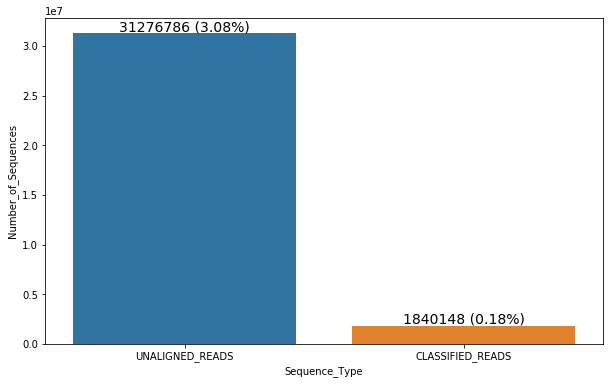

In [308]:
ax = plt.figure(figsize=(10,6))
ax = sns.barplot(x="Sequence_Type", y="Number_of_Sequences", data=total_df)
ax.text(0, 31276786+250000, '31276786 (3.08%)', color='black', ha="center", fontsize=14)
ax.text(1, 1840148+250000, '1840148 (0.18%)', color='black', ha="center", fontsize=14)
plt.savefig('../results/figures/data_qc.png')

In [239]:
print("Total number of unaligned reads: {} ({}%%)".format(totals.loc["UNALIGNED_READS"], totals.loc["UNALIGNED_READS"]/totals.loc["RAW_READS"]*100))

Total number of unaligned reads: 31276786 (3.0809949121843307%%)


In [241]:
print("Total number of classfied reads: {} ({}%%)".format(totals.loc["CLASSIFIED_READS"], totals.loc["CLASSIFIED_READS"]/totals.loc["RAW_READS"]*100))

Total number of classfied reads: 1840148 (0.1812681976231884%%)


## Feature table overview
1. Load metadata
2. Visualize feature table statistics
2. Save as pd.DataFrame
3. Grab per feature counts

#### Load metadata

In [28]:
m_data = qiime2.Metadata.load('{}/sample_metadata.tsv'.format(data_dir))

In [29]:
metadata_df = m_data.to_dataframe()

In [30]:
metadata_df.head()

,gender,condition,recurrence
sampleid,,,
SRR9094428.unmapped,female,cancer,yes
SRR9094429.unmapped,female,cancer,yes
SRR9094430.unmapped,female,cancer,yes
SRR9094431.unmapped,female,cancer,yes
SRR9094432.unmapped,female,cancer,yes


In [31]:
f_table = qiime2.Artifact.load('{}/feature-table.qza'.format(data_dir))

In [310]:
#qiime2.Visualization.load('{}/feature-table.qzv'.format(data_dir))

In [33]:
feature_df = f_table.view(pd.DataFrame)

In [34]:
feature_df.head()

,80840,119060,32008,292,482957,60552,179879,488731,95486,60550,...,336988,712528,1954172,120962,106,2025876,277944,1714845,1349,1299
SRR9094428.unmapped,225.0,37.0,395.0,322.0,52.0,30.0,22.0,21.0,17.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR9094429.unmapped,519.0,228.0,980.0,847.0,51.0,0.0,1.0,15.0,54.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR9094430.unmapped,168.0,53.0,353.0,203.0,10.0,0.0,0.0,18.0,30.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR9094431.unmapped,61.0,38.0,211.0,174.0,17.0,0.0,4.0,4.0,24.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR9094432.unmapped,79.0,42.0,310.0,207.0,23.0,0.0,0.0,1.0,51.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
feature_df.to_csv('{}/dataframes/feature_table.tsv'.format(data_dir), '\t', index=True)

In [36]:
feature_counts = pd.DataFrame(feature_df.sum(axis=0), columns=["count"])

In [37]:
feature_counts.head()

,count
80840,67624.0
119060,13576.0
32008,51119.0
292,35766.0
482957,3887.0


## Taxonomic clasification overview
1. Plot taxominc grouping fractions
2. Plot relative taxonomies in barplot

In [38]:
tax = qiime2.Artifact.load('{}/feature-taxonomy.qza'.format(data_dir))

In [312]:
#qiime2.Visualization.load('{}/feature-taxonomy.qzv'.format(data_dir))

In [40]:
tax_df = tax.view(pd.DataFrame)

In [41]:
tax_df.head()

,Taxon
Feature ID,
80840,k__Bacteria; p__Proteobacteria; c__Betaproteob...
119060,k__Bacteria; p__Proteobacteria; c__Betaproteob...
32008,k__Bacteria; p__Proteobacteria; c__Betaproteob...
292,k__Bacteria; p__Proteobacteria; c__Betaproteob...
482957,k__Bacteria; p__Proteobacteria; c__Betaproteob...


In [42]:
tax_df.to_csv('{}/dataframes/feature_taxonomy.tsv'.format(data_dir), '\t', index=True)

In [43]:
taxon_counts = {"k":0, "p":0, "c":0, "o":0, "f":0, "g":0, "s":0}
for classification in tax_df["Taxon"].values:
    taxons = classification.split('; ')
    for i, cl in enumerate(taxons):
        if i > 0 and len(cl) < 4:
            taxon_counts[taxons[i-1][0]] += 1
            break
        if i == len(taxons)-1:
            taxon_counts[taxons[len(taxons)-1][0]] += 1

In [44]:
taxon_counts = pd.Series(taxon_counts)

In [45]:
taxon_frac = taxon_counts/taxon_counts.sum()

In [100]:
set_three = cm.get_cmap('Set3', 20)

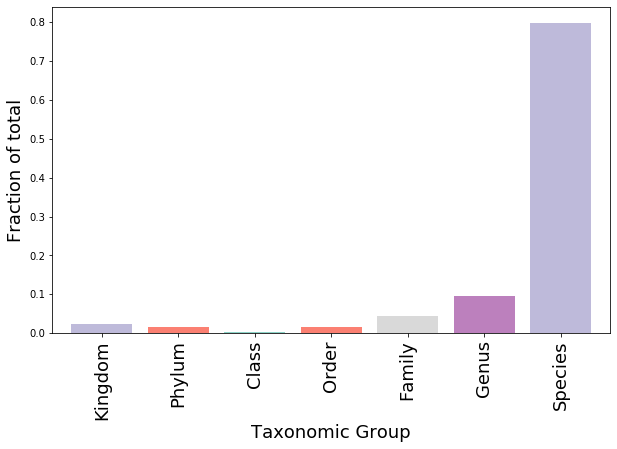

In [314]:
ax = plt.figure(figsize=(10,6))
ax = taxon_frac.plot.bar(color=[set_three(np.random.random()) for i in range(len(taxon_frac))], width=0.8)
ax.set_xlabel("Taxonomic Group", fontsize=18)
ax.set_ylabel("Fraction of total", fontsize=18)
ax.set_xticklabels(["Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"], fontsize=18)
plt.savefig('../results/figures/taxon_groupings.png')

In [104]:
taxa_barplot = taxa.visualizers.barplot(table=f_table,
                         taxonomy=tax,
                         metadata=m_data)

In [317]:
#taxa_barplot.visualization

## Diversity analysis
1. Rarefaction (alpha and beta)
2. Core diversity (alpha and beta)

In [123]:
alpha_rare = diversity.visualizers.alpha_rarefaction(table=f_table,
                                                    max_depth=10000,
                                                    metrics=set(['shannon', 'observed_otus']),
                                                    metadata=m_data)

In [280]:
#alpha_rare.visualization

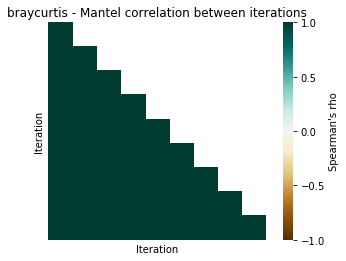

In [131]:
beta_rare = diversity.visualizers.beta_rarefaction(table=f_table,
                                                   clustering_method='upgma',
                                                   sampling_depth=10000,
                                                   metric='braycurtis',
                                                   metadata=m_data)

In [117]:
core_diversity = diversity.pipelines.core_metrics(table=f_table,
                                                  sampling_depth=1000,
                                                  metadata=m_data)

/Users/adamklie/anaconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/adamklie/anaconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.09867305623715426 and the largest is 7.9044895436985465.
  RuntimeWarning


In [301]:
shannon_sig = diversity.visualizers.alpha_group_significance(core_diversity.shannon_vector,
                                              metadata=m_data)
otu_sig = diversity.visualizers.alpha_group_significance(core_diversity.observed_otus_vector,
                                              metadata=m_data)
eveness_sig = diversity.visualizers.alpha_group_significance(core_diversity.evenness_vector,
                                              metadata=m_data)

In [303]:
#eveness_sig.visualization

In [154]:
diversity_df = pd.concat([metadata_df, 
                          core_diversity.observed_otus_vector.view(pd.Series), 
                          core_diversity.shannon_vector.view(pd.Series),
                          core_diversity.evenness_vector.view(pd.Series)], axis=1, join='inner') 

In [156]:
diversity_df.head()

,gender,condition,recurrence,observed_otus,shannon,pielou_e
SRR9094428.unmapped,female,cancer,yes,101,5.295862,0.795388
SRR9094429.unmapped,female,cancer,yes,101,5.021404,0.754167
SRR9094430.unmapped,female,cancer,yes,107,4.821459,0.715194
SRR9094431.unmapped,female,cancer,yes,106,5.070462,0.753645
SRR9094432.unmapped,female,cancer,yes,91,5.003407,0.768833


In [305]:
diversity_df.groupby("condition").count()

,gender,recurrence,observed_otus,shannon,pielou_e
condition,,,,,
cancer,81,81,81,81,81
normal,32,0,32,32,32


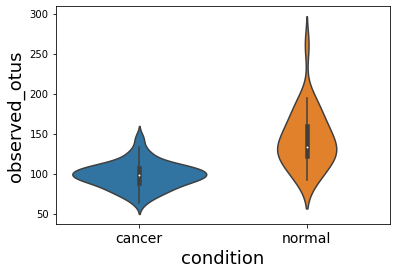

In [319]:
ax = sns.violinplot(x="condition", y="observed_otus", data=diversity_df)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
plt.savefig('../results/figures/cancer_otu_alpha_sig.png')

In [320]:
#core_diversity.jaccard_emperor

## Sample Classification
1. Save DataFrames with
 - Feature details
 - Test set classifcation results

In [389]:
# Choose model version
version = 'v1'
class_dir = '{}/dataframes/classification_{}'.format(data_dir, version)

In [390]:
class_dir

'../results/qiime/dataframes/classification_v1'

In [391]:
# Choose either 'cancer' or 'recurrence'
classification_type = 'recurrence'
cancer_dir = '{}/{}_classification/{}'.format(data_dir, classification_type, version)
cancer_dir

'../results/qiime/recurrence_classification/v1'

##### Model

In [392]:
#qiime2.Visualization.load('{}/accuracy_results.qzv'.format(cancer_dir))
#qiime2.Visualization.load('{}/model_summary.qzv'.format(cancer_dir))
#qiime2.Visualization.load('{}/heatmap.qzv'.format(cancer_dir))

##### Features

In [393]:
importance_df = qiime2.Artifact.load('{}/feature_importance.qza'.format(cancer_dir)).view(pd.DataFrame)

In [394]:
model_features = pd.concat([tax_df, importance_df, feature_counts], axis=1, join='inner')

In [413]:
[print(';'.join(i.split(';')[:])) for i in model_features.sort_values("importance", ascending=False).head(n=10)["Taxon"].values]

k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Staphylococcaceae; g__Staphylococcus; s__saprophyticus
k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Prevotella; s__melaninogenica
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Burkholderiaceae; g__Paraburkholderia; s__fungorum
k__Bacteria; p__Bacteroidetes; c__Chitinophagia; o__Chitinophagales; f__Chitinophagaceae; g__; s__
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Pseudomonadaceae; g__Pseudomonas; s__moraviensis
k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Staphylococcaceae; g__Staphylococcus; s__epidermidis
k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Methylobacteriaceae; g__Microvirga; s__sp. 17 mud 1-3
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Burkholderiaceae; g__Burkholderia; s__cepacia
k__Bacteria; p__Actinobacteria; c__Actinobacteria;

[None, None, None, None, None, None, None, None, None, None]

In [396]:
model_features.to_csv('{}/{}_model_features_{}.tsv'.format(class_dir, classification_type, version), sep='\t')

##### Samples

In [397]:
prediction_s = qiime2.Artifact.load('{}/predictions.qza'.format(cancer_dir)).view(pd.Series)
probability_df = qiime2.Artifact.load('{}/probabilities.qza'.format(cancer_dir)).view(pd.DataFrame)
estimator = qiime2.Artifact.load('{}/sample_estimator.qza'.format(cancer_dir))

In [398]:
estimator.export_data(cancer_dir)

In [399]:
probability_df.shape

(20, 2)

In [400]:
prediction_df = pd.DataFrame(data=prediction_s.values, index=prediction_s.index, columns = ["predicted_label"])

In [401]:
model_predictions = pd.concat([probability_df, prediction_df], axis=1, join='inner')

In [402]:
model_predictions.head()

,no,yes,predicted_label
id,,,
SRR9094487.unmapped,0.87,0.13,no
SRR9094472.unmapped,0.90,0.10,no
SRR9094447.unmapped,0.76,0.24,no
SRR9094515.unmapped,0.89,0.11,no
SRR9094490.unmapped,1.00,0.00,no


In [403]:
model_samples = metadata_df.merge(model_predictions, left_index=True, right_index=True)

In [404]:
model_samples.head()

,gender,condition,recurrence,no,yes,predicted_label
SRR9094429.unmapped,female,cancer,yes,0.85,0.15,no
SRR9094440.unmapped,female,cancer,yes,0.99,0.01,no
SRR9094441.unmapped,female,cancer,yes,0.48,0.52,yes
SRR9094444.unmapped,female,cancer,yes,0.65,0.35,no
SRR9094447.unmapped,female,cancer,yes,0.76,0.24,no


In [405]:
model_samples.to_csv('{}/{}_model_predictions_{}.tsv'.format(class_dir, classification_type, version), sep='\t')

## Differential abundance

In [370]:
recurrence_m_data = qiime2.Metadata.load('{}/recurrence_metadata.tsv'.format(data_dir))

In [373]:
recurrence_metadata_df = m_data.to_dataframe()

In [374]:
recurrence_metadata_df.head()

,gender,condition,recurrence
sampleid,,,
SRR9094428.unmapped,female,cancer,yes
SRR9094429.unmapped,female,cancer,yes
SRR9094430.unmapped,female,cancer,yes
SRR9094431.unmapped,female,cancer,yes
SRR9094432.unmapped,female,cancer,yes


In [380]:
recurrence_f_table = qiime2.Artifact.load('{}/recurrence-table.qza'.format(data_dir))

In [381]:
#qiime2.Visualization.load('{}/feature-table.qzv'.format(data_dir))

In [384]:
recurrence_feature_df = recurrence_f_table.view(pd.DataFrame)

In [387]:
num_samples = len(recurrence_feature_df)
test_examples = int(num_samples*0.2)
#cancer_form = "C(condition, Treatment('normal'))"
recurrence_form = "C(recurrence, Treatment('no'))"

In [388]:
covariate_model = songbird.methods.multinomial(table=recurrence_f_table,
                                               metadata=recurrence_m_data,
                                               formula=recurrence_form,
                                               num_random_test_examples=test_examples,
                                               epochs=10000,
                                               batch_size=32,
                                               differential_prior=0.2,
                                               random_seed=13)

100%|██████████| 10000/10000 [00:44<00:00, 222.90it/s]


In [349]:
null_model = songbird.methods.multinomial(table=recurrence_f_table,
                                          metadata=recurrence_m_data,
                                          formula="1",
                                          num_random_test_examples=test_examples,
                                          epochs=10000,
                                          batch_size=32,
                                          differential_prior=0.2,
                                          random_seed=13)

100%|██████████| 20000/20000 [03:01<00:00, 109.96it/s]


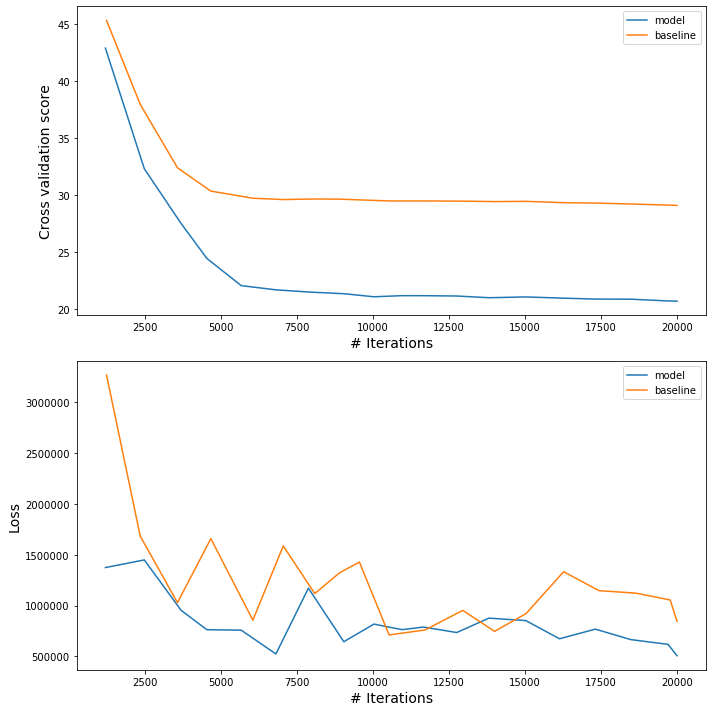

In [358]:
songbird_vis = songbird.visualizers.summarize_paired(regression_stats=covariate_model.regression_stats, 
                                                     baseline_stats=null_model.regression_stats)
#songbird_vis.visualization

In [406]:
differential_df = covariate_model.differentials.view(pd.DataFrame)

In [407]:
differential_df.head()

,Intercept,"C(recurrence, Treatment('no'))[T.yes]"
featureid,,
80840,3.647085,0.429294
119060,3.211137,0.138417
32008,4.941103,0.023816
292,4.629067,-0.114727
482957,2.451079,0.055088


In [408]:
#diff_features = pd.concat([model_features, differential_df["C(condition, Treatment('normal'))[T.cancer]"]], axis=1, join='inner')
diff_features = pd.concat([model_features, differential_df["C(recurrence, Treatment('no'))[T.yes]"]], axis=1, join='inner')

In [409]:
#diff_features.rename(columns={"C(condition, Treatment('normal'))[T.cancer]":"Differential"}, inplace=True)
diff_features.rename(columns={"C(recurrence, Treatment('no'))[T.yes]":"Differential"}, inplace=True)

In [410]:
important_diff_features = diff_features.sort_values("importance", ascending=False)
important_diff_features.to_csv('{}/{}_diff_features_{}.tsv'.format(class_dir, classification_type, version), sep='\t')

In [95]:
feature_m_data = tax.view(qiime2.Metadata)

In [97]:
differential_vis = qurro.visualizers.differential_plot(ranks=covariate_model.differentials,
                                    table=f_table,
                                    sample_metadata=m_data,
                                    feature_metadata=feature_m_data)

2748 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.


In [99]:
differential_vis.visualization

<visualization: Visualization uuid: b6a33c00-6094-413b-ada5-d112e019eef9>